In [57]:
import pandas as pd
import pyreadr

result = pyreadr.read_r("5v_cleandf.rdata") 

df = result['df']

df.head()

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
0,B,4,40,Male,Hispanic or Latino,White or Caucasian,English,None,Single,Full Time,...,0,0,0,0,0,0,0,0,0,0
1,B,4,66,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0,0,0,0,0,0,0,0,0,0
2,B,2,66,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0,0,0,0,0,0,0,0,0,0
3,A,2,66,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0,0,0,0,0,0,0,0,0,0
4,A,3,84,Female,Hispanic or Latino,Other,Other,Pentecostal,Widowed,Retired,...,0,0,0,0,0,0,0,0,0,0


In [46]:
#df.to_csv("Hospital Triage and Patient History.csv",index=False)

In [64]:
# Elimina las columnas donde todos sus elementos sean iguales
columns_to_remove = df.columns[df.nunique() == 1]
df_witout_nunique = df.drop(columns=columns_to_remove)
df_witout_nunique.head()

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
0,B,4,40,Male,Hispanic or Latino,White or Caucasian,English,None,Single,Full Time,...,0,0,0,0,0,0,0,0,0,0
1,B,4,66,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0,0,0,0,0,0,0,0,0,0
2,B,2,66,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0,0,0,0,0,0,0,0,0,0
3,A,2,66,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0,0,0,0,0,0,0,0,0,0
4,A,3,84,Female,Hispanic or Latino,Other,Other,Pentecostal,Widowed,Retired,...,0,0,0,0,0,0,0,0,0,0


In [58]:
significantColumns = ['cc_chestpain', 'cc_breathingdifficulty', 'cc_syncope', 'cc_unresponsive', 'cc_seizure-newonset', 'cc_seizure-priorhxof', 'cc_seizures', 'cc_bleeding/bruising', 'cc_hyperglycemia', 'cc_hypertension', 'cc_hypotension', 'cc_strokealert', 'cc_overdose-accidental', 'cc_overdose-intentional', 'cc_suicidal']

In [78]:
# If any of the significant columns are on true, automatically has the flag of emergency
df_witout_nunique['emergency_flag_column'] = df_witout_nunique[significantColumns].any(axis=1)

print(df_witout_nunique['emergency_flag_column'].value_counts())

False    493625
True      66861
Name: emergency_flag_column, dtype: int64


In [79]:
from sklearn.preprocessing import LabelEncoder
df_converted = df_witout_nunique.copy()

# Inicializar el codificador de etiquetas
label_encoder = LabelEncoder()

# Identificar las variables categóricas
categorical_columns = []
for column in df_converted.columns:
    # Verificar si la columna es de tipo 'object' o 'category'
    if df_converted[column].dtype == 'object' or df_converted[column].dtype == 'category' :  
        categorical_columns.append(column)

# Convertir las variables categóricas usando LabelEncoder
for column in categorical_columns:
    df_converted[column] = label_encoder.fit_transform(df_converted[column])

print(df_converted['gender'].value_counts())


0    309653
1    250833
Name: gender, dtype: int64


In [106]:
columnsWithNan = df_converted.isna().any().pipe(lambda x: x.index[x])
print(len(columnsWithNan))

# Reemplazo los valores nulos con -999. Se podría intentar en una proxima iteracion con algo como col.mode()[0] o valores significativos reales
df_filled = df_converted.apply(lambda col: col.fillna(-999))

newColumnsWithNan = df_filled.isna().any().pipe(lambda x: x.index[x])
print(len(newColumnsWithNan))


386
0


In [107]:
# Entrenamiento del modelo
from sklearn.ensemble import RandomForestClassifier
# División de datos
X = df_filled.drop(columns=['emergency_flag_column'])
y = df_filled['emergency_flag_column']

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [112]:
# Validación del modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9967528412638941


In [113]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
FP = confusion[0, 1]
TN = confusion[0, 0]
FN = confusion[1, 0]

print("verdaderos positivos: "+ TP)

In [ ]:
# Codificación de variables categóricas
df_encoded = pd.get_dummies(df_witout_nunique)

In [ ]:
from sklearn.impute import SimpleImputer

# Manejo de valores nulos
imputer = SimpleImputer(strategy='most_frequent')  
df_without_null = imputer.fit_transform(df_witout_nunique)
print(df_without_null)

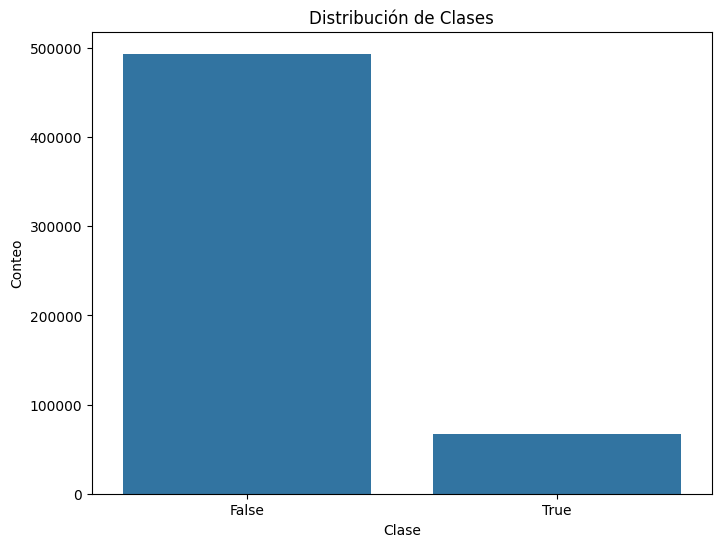

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un DataFrame con las características y las etiquetas codificadas
df_plot = X.copy()
df_plot['emergency_flag'] = y

# Graficar la distribución de las clases
plt.figure(figsize=(8, 6))
sns.countplot(x='emergency_flag', data=df_plot)
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Conteo')
plt.show()